In [12]:
!git clone 'https://github.com/Lorenz92/SKADC1.git'
% cd SKADC1
!echo $PWD

Cloning into 'SKADC1'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 41 (delta 17), reused 25 (delta 6), pack-reused 0
Unpacking objects: 100% (41/41), done.


In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import sys
from astropy.io import fits
import os

import src.dataset as dataset
import src.config as config
from src.utils import *
import src.preprocessing as prep

# from src.config import * 

%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

In [7]:
for download_info in config.required_files:
    if not os.path.exists(os.path.join(config.TRAIN_DATA_FOLDER, download_info['file_name'])):
        download_data(download_info['file_name'], download_info['url'], config.DOWNLOAD_FOLDER)

Download completed!
Download completed!


In [2]:
# Dataset parsing and loading
# use "subset" to load a small portion of data for development/debugging purposes

ska_dataset = dataset.SKADataset(train_set_path=config.TRAIN_SET_PATH, subset=config.DATA_SUBSET)
print(ska_dataset.raw_train_df.shape)
ska_dataset.raw_train_df.head()

(19222, 15)


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,SIZE,CLASS,SELECTION,x,y
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,1,1,1,19704.519,17712.942
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,1,1,1,18401.338,17160.919
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,1,1,1,16493.600,18506.577
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,2,1,1,18020.319,18182.095
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,1,1,1,18125.824,18600.680


In [3]:
data_560Mhz_1000h_fits = fits.open('./data/training/560Mhz_1000h.fits')
# data_560Mhz_1000h_fits.info()
data_560Mhz_1000h_fits.filename()

# print(data_560Mhz_1000h_fits[0].data)
# print(data_560Mhz_1000h_fits[0].data.shape)

data_560Mhz_1000h = data_560Mhz_1000h_fits[0].data[0,0]


In [28]:
# Visualization test
from astropy.io import fits
from astropy.utils.data import download_file

# image_file = download_file('https://owncloud.ia2.inaf.it/index.php/s/hbasFhd4YILNkCr/download', cache=True )

# image_data = fits.getdata(image_file)
# image_data = image_data.reshape(image_data.shape[2:])

# compute per value to clip the image
perc = 99.9
percentileThresh = np.percentile(data_560Mhz_1000h, perc)
print (f'{perc} percentile {percentileThresh}')

# # crop the image to speed up computation and clip using per value
# image_crop= image_data[5000:10000, 5000:10000]
# image_crop.clip(max=percentileThresh)

# plt.figure(figsize=(100, 100))
# # plt.imshow(normalized_data, cmap='viridis', vmax=255, vmin=0)
# for idx in range(25):
#     plt.subplot(5, 5, idx+1)
#     plt.axis('off')
#     base = 200 * idx
#     end = base + 200
#     normalized_data = image_crop[base:end, base:end] * (1.0 / percentileThresh)
#     plt.imshow(normalized_data, cmap='viridis', vmax=1, vmin=0)

99.9 percentile 8.316711500810925e-06


### Preprocessing

In [4]:
coords = ska_dataset._convert_boxes_to_px_coord(ska_dataset.raw_train_df, data_560Mhz_1000h_fits[0].header)

In [5]:
pd.DataFrame.from_dict(coords)

,x1,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height
0,19699.889820,17708.334874,19709.135520,17717.543623,4.633850,4.593304,5.734349,9.245699,9.208748
1,18314.128617,17121.775102,18488.540079,17200.059688,88.630651,35.798972,3.338082,174.411463,78.284586
2,16490.663037,18502.418816,16496.536575,18510.726749,4.167982,2.916843,4.827354,5.873538,8.307933
3,18019.631633,18181.823147,18020.999232,18182.360119,0.700870,0.220108,6.050027,1.367598,0.536972
4,18124.509296,18597.936034,18127.132703,18603.414392,2.766243,1.253622,4.869573,2.623407,5.478358
...,...,...,...,...,...,...,...,...,...
19217,17592.572752,16742.936603,17593.009233,16743.428821,0.319405,0.078610,0.853117,0.436482,0.492218
19218,18658.822580,18666.464880,18659.100383,18666.968994,0.276376,0.080265,1.127797,0.277803,0.504113
19219,17523.170058,16995.697610,17523.352636,16995.761662,0.093504,0.024824,-0.226387,0.182578,0.064053
19220,16950.523810,17747.923087,16950.979337,17748.452311,0.264791,0.227555,-1.498732,0.455528,0.529224


In [6]:
df_train = ska_dataset._extend_dataframe(ska_dataset.raw_train_df, coords)
df_train.head()

,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,y,x1,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,...,17712.942,19699.889820,17708.334874,19709.135520,17717.543623,4.633850,4.593304,5.734349,9.245699,9.208748
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,...,17160.919,18314.128617,17121.775102,18488.540079,17200.059688,88.630651,35.798972,3.338082,174.411463,78.284586
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,...,18506.577,16490.663037,18502.418816,16496.536575,18510.726749,4.167982,2.916843,4.827354,5.873538,8.307933
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,...,18182.095,18019.631633,18181.823147,18020.999232,18182.360119,0.700870,0.220108,6.050027,1.367598,0.536972
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,...,18600.680,18124.509296,18597.936034,18127.132703,18603.414392,2.766243,1.253622,4.869573,2.623407,5.478358


In [7]:
x1_min = int(np.floor(min(df_train['x1'])))
y1_min = int(np.floor(min(df_train['y1'])))

x2_max = int(np.floor(max(df_train['x2'])))
y2_max = int(np.floor(max(df_train['y2'])))

data_560Mhz_1000h_train = data_560Mhz_1000h[y1_min:y2_max, x1_min:x2_max]
data_560Mhz_1000h_train.shape


(3187, 3491)

(array([7.000000e+00, 3.500000e+01, 1.490000e+02, 4.570000e+02,
        1.414000e+03, 3.784000e+03, 9.359000e+03, 2.169900e+04,
        4.657800e+04, 9.096100e+04, 1.648540e+05, 2.743260e+05,
        4.212290e+05, 6.021740e+05, 7.904020e+05, 9.590150e+05,
        1.079217e+06, 1.124733e+06, 1.086416e+06, 9.748840e+05,
        8.142290e+05, 6.389060e+05, 4.715880e+05, 3.307770e+05,
        2.255350e+05, 1.517900e+05, 1.038090e+05, 7.363900e+04,
        5.517600e+04, 4.409500e+04, 3.635000e+04, 3.138700e+04,
        2.764800e+04, 2.443600e+04, 2.195700e+04, 1.978300e+04,
        1.802900e+04, 1.622400e+04, 1.505500e+04, 1.416400e+04]),
 array([-1.9004023e-06, -1.8053821e-06, -1.7103621e-06, -1.6153419e-06,
        -1.5203218e-06, -1.4253017e-06, -1.3302815e-06, -1.2352615e-06,
        -1.1402414e-06, -1.0452212e-06, -9.5020113e-07, -8.5518104e-07,
        -7.6016090e-07, -6.6514076e-07, -5.7012068e-07, -4.7510056e-07,
        -3.8008045e-07, -2.8506034e-07, -1.9004023e-07, -9.5020113e-08

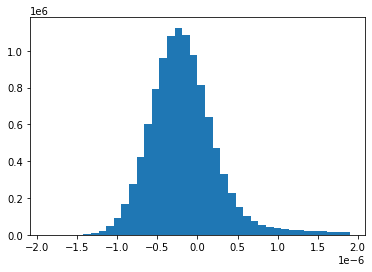

In [8]:
# histogram of noise (- noise, + noise)
# we know that negative values are due to noise, and we assume a gaussian noise distribution

data_flat = data_560Mhz_1000h_train.flatten()
min_val = min(data_flat)
plt.hist(data_flat, bins = 40, range = (min_val, abs(min_val)))

In [8]:
fits_max_data_560Mhz_1000h = np.max(data_560Mhz_1000h)
print(fits_max_data_560Mhz_1000h)

data_560Mhz_1000h_train_clipped = np.clip(data_560Mhz_1000h_train, a_min=0, a_max=fits_max_data_560Mhz_1000h)

0.48094657


In [10]:
data_560Mhz_1000h_train_clipped

array([[0.0000000e+00, 5.0277004e-07, 8.1352823e-07, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 4.7234460e-07, 7.5504875e-07, ..., 0.0000000e+00,
        0.0000000e+00, 1.5155882e-07],
       [0.0000000e+00, 0.0000000e+00, 4.7753889e-07, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 3.2216460e-07, 2.1111914e-07, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        4.3899996e-07, 6.1143220e-07]], dtype=float32)

In [9]:
patches={}
patches = ska_dataset._split_in_patch(data_560Mhz_1000h_train_clipped, df_train, data_560Mhz_1000h_fits.filename(), x1_min, y1_min, 205) # Remember to remove internal return

image saved
Index(['ID', 'RA (core)', 'DEC (core)', 'RA (centroid)', 'DEC (centroid)',
       'FLUX', 'Core frac', 'BMAJ', 'BMIN', 'PA', 'SIZE', 'CLASS', 'SELECTION',
       'x', 'y', 'x1', 'y1', 'x2', 'y2', 'major_semia_px', 'minor_semia_px',
       'pa_in_rad', 'width', 'height', 'x1s', 'y1s', 'x2s', 'y2s',
       'patch_name', 'patch_xo', 'patch_yo', 'patch_dim'],
      dtype='object')
         ID  RA (core)  DEC (core)  RA (centroid)  DEC (centroid)      FLUX  \
0  27514971  -0.014459  -29.933004      -0.014121      -29.932705  0.039324   
1  15252327  -0.039005  -29.915081      -0.039002      -29.915081  0.000010   
2  13302538  -0.005224  -29.939449      -0.005224      -29.939449  0.000017   
3  30994188  -0.035645  -29.910868      -0.035645      -29.910868  0.000934   
4  29158240  -0.002566  -29.917469      -0.002566      -29.917469  0.000036   

   Core frac    BMAJ    BMIN       PA  ...      width     height         x1s  \
0   0.004216  31.508  17.616  353.308  ...  51.900100

In [10]:
# test if file has been correctly saved

patch = '0_1638016380_205.npy'
pkl = '0_1638016380_205.pkl'

path = os.path.join(config.TRAIN_PATCHES_FOLDER, '0_1638016380_205/')
p = np.load(os.path.join(path, patch))
pdata = pd.read_pickle(os.path.join(path, pkl))
print(p)
print(pdata)
b.dtypes

[[0.0000000e+00 5.0277004e-07 8.1352823e-07 ... 2.1992520e-07
  3.3757752e-07 8.9618879e-08]
 [0.0000000e+00 4.7234460e-07 7.5504875e-07 ... 0.0000000e+00
  2.7678368e-08 3.8842813e-08]
 [0.0000000e+00 0.0000000e+00 4.7753889e-07 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.6627402e-07 2.2166087e-07 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.3635220e-07 2.9386493e-07 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]
          ID  RA (core)  DEC (core)  RA (centroid)  DEC (centroid)      FLUX  \
0   27514971  -0.014459  -29.933004      -0.014121      -29.932705  0.039324   
1   15252327  -0.039005  -29.915081      -0.039002      -29.915081  0.000010   
2   13302538  -0.005224  -29.939449      -0.005224      -29.939449  0.000017   
3   30994188  -0.035645  -29.910868      -0.035645      -29.910868  0.000934   
4   29158240  -0.002566  -29.917469 

NameError: name 'b' is not defined

#TODO:
- Ingrandire bbox
- unire bbox sovrapposte
- Mergiare branch data_clean (anche alla fine)
- Quando vengono create le patch, ritagliare le bbox per farle stare tutte nella patch X
- Check tra nostro dataset pulito e quello di ICRAR (dopo aver mergiato il branch data_clean)

Da capire per la rete:
- bisogna scalre input tra 0 e 255 intero?
- salvare le patch come immagini o possiamo darle in input on the fly?
- è necessario un custom input layer che converte le nostra immagini da 1 a 3 canali?

In [31]:
# Download VGG16 weights
# 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
if not os.path.exists(os.path.join(config.MODEL_WEIGHTS, 'vgg16')):
    download_data('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
    'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', config.MODEL_WEIGHTS + '/vgg16')


In [120]:
# First net version
import keras
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Concatenate

FROZEN_LAYERS_IDX = [1, 2, 4, 5]
ANCHOR_NUM = 30
PROB_PRED_OUT = 2 * ANCHOR_NUM
COORD_PRED_OUT = 4 * ANCHOR_NUM 
input_shape=(205, 205, 1) #TODO: change to 205,205,1

vgg16_weight_path = os.path.join('./model/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Add custom input-layer to change from1 to 3 channels
inp = Input(input_shape)
expander_layer = Conv2D(filters=3, kernel_size=(1, 1), padding='same', activation='relu', name='Custom_input_layer')(inp)

'''
# Load pretrained VGG16 and remove last MaxPool layer
# VGG16 = keras.applications.VGG16(include_top=False, weights="imagenet", pooling=None) # Commentato perchè non siamo riusciti a togliere l'ultimo layer
# x = x(expander_layer)
'''

# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', trainable=False)(expander_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', trainable=False)(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', trainable=False)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', trainable=False)(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
# x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

# Create Region Proposal Net
x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='18_RPN_Conv1')(x)
cls_pred = Conv2D(filters=PROB_PRED_OUT, kernel_size=(1, 1), padding='same', activation='sigmoid', name='19_Anchor_Cls_Conv')(x) #output of layer 20
reg_pred = Conv2D(filters=COORD_PRED_OUT, kernel_size=(1, 1), padding='same', activation='linear', name='19_Anchor_Reg_Conv')(x) #output of layer 19

anch_target_cls = Reshape((cls_pred.shape[1]**2, cls_pred.shape[3]), name='20_Anchor_Target_cls')(cls_pred)
anch_target_reg = Reshape((reg_pred.shape[1]**2, reg_pred.shape[3]), name='20_Anchor_Target_reg')(reg_pred)

print(cls_pred)

# region_prop_net = keras.Model(inp, [cls_pred, reg_pred], name='RegionProposal')
region_prop_net = keras.Model(inp, cls_pred, name='RegionProposal')

region_prop_net.load_weights(vgg16_weight_path, by_name=True)

region_prop_net.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 60), dtype=tf.float32, name=None), name='19_Anchor_Cls_Conv/Sigmoid:0', description="created by layer '19_Anchor_Cls_Conv'")
Model: "RegionProposal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 205, 205, 1)]     0         
_________________________________________________________________
Custom_input_layer (Conv2D)  (None, 205, 205, 3)       6         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 205, 205, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 205, 205, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 102, 102, 64)      0         
_________________________________________________________________
block

In [128]:
lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0

lambda_cls_regr = 1.0
lambda_cls_class = 1.0

epsilon = 1e-4

def rpn_loss_regr(num_anchors):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def rpn_loss_regr_fixed_num(y_true, y_pred):

        # x is the difference between true value and predicted value
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred

        # absolute value of x
        x_abs = K.abs(x)

        # If x_abs <= 1.0, x_bool = 1
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

        return lambda_rpn_regr * K.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

    return rpn_loss_regr_fixed_num

def rpn_loss_cls(num_anchors):
    """Loss function for rpn classification
    Args:
        num_anchors: number of anchors (9 in here)
        y_true[:, :, :, :9]: [0,1,0,0,0,0,0,1,0] means only the second and the eighth box is valid which contains pos or neg anchor => isValid
        y_true[:, :, :, 9:]: [0,1,0,0,0,0,0,0,0] means the second box is pos and eighth box is negative
    Returns:
        lambda * sum((binary_crossentropy(isValid*y_pred,y_true))) / N
    """
    def rpn_loss_cls_fixed_num(y_true, y_pred):
            print(y_true)
            print(y_pred)

            return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :num_anchors], y_true[:, :, :, :num_anchors])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])
            

    return rpn_loss_cls_fixed_num

In [129]:
from keras.optimizers import Adam

num_anchors = 30

optimizer = Adam(lr=1e-5)
optimizer_classifier = Adam(lr=1e-5)
# region_prop_net.compile(optimizer=optimizer, loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)])
region_prop_net.compile(optimizer=optimizer, loss=rpn_loss_cls(num_anchors))

In [14]:
a,b,c = prep.calc_rpn(pdata.head(1), 205, 205, 205, 205)

1
0
ID                                27514971
RA (core)                        -0.014459
DEC (core)                      -29.933004
RA (centroid)                    -0.014121
DEC (centroid)                  -29.932705
FLUX                              0.039324
Core frac                         0.004216
BMAJ                                31.508
BMIN                                17.616
PA                                 353.308
SIZE                                     1
CLASS                                    1
SELECTION                                1
x                                16455.911
y                                16783.927
x1                            16429.960356
y1                            16769.133503
x2                            16481.860456
y2                            16798.719143
major_semia_px                   26.072025
minor_semia_px                   14.576767
pa_in_rad                         6.166388
width                              51.9001
height 

In [15]:
print(a.shape)
print(b.shape)
print(c)

(1, 60, 12, 12)
(1, 240, 12, 12)
1


TODO - 20210502:
- X creare colonne per coordinate bbox nel sistema di riferimento della patch
- X creare cartelle per patches con npy + pkl delle sue sole bbox
- ragionare su dimensioni patch
- X Caricare pesi VGG16 nel nuovo network
- lanciare training

TODO - 20210508:
- zero centering patch by patch
- troncamento rumore a 1e-6
- portare branch o funzioni di data_clean in main
- img augmentation -> augment()

In [38]:
a = np.transpose(a, (0, 2, 3, 1))
print(a.shape)
b = np.transpose(b, (0, 2, 3, 1))
print(b.shape)

(1, 12, 12, 60)
(1, 12, 12, 240)


In [49]:
p = np.expand_dims(p, axis=0)


In [54]:
p = np.transpose(p, (1,2,0))
p.shape

(205, 205, 1)

In [59]:
p = np.expand_dims(p, axis=0)
p.shape


(1, 205, 205, 1)

In [77]:

type(p)

numpy.ndarray

In [130]:
# Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
loss_rpn = region_prop_net.train_on_batch(p, a)
print(loss_rpn)

# Get predicted rpn from rpn model [rpn_cls, rpn_regr]
P_rpn = region_prop_net.predict_on_batch(p)
P_rpn[0].shape

Tensor("IteratorGetNext:1", shape=(1, 12, 12, 60), dtype=float32)
Tensor("RegionProposal/19_Anchor_Cls_Conv/Sigmoid:0", shape=(1, 12, 12, 60), dtype=float32)
Tensor("IteratorGetNext:1", shape=(1, 12, 12, 60), dtype=float32)
Tensor("RegionProposal/19_Anchor_Cls_Conv/Sigmoid:0", shape=(1, 12, 12, 60), dtype=float32)
9.86532211303711


(12, 12, 60)

In [ ]:
#TODO: Provare YOLO che ad Asperti piace
# Ablation study
# Provare, a parità di frequenza, le esposizioni diverse come canali